<a href="https://colab.research.google.com/github/chenny317/iat360_final/blob/main/IAT360_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import required libraries

In [106]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import re, string

Load dataset

In [107]:
#importing the dataset
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

## Looking at the data

The training data contains a row per comment, with an id, the text of the comment, and 6 different labels that we'll try to predict.

In [108]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Here's a couple of examples of comments, one toxic, and one with no labels.

In [109]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [110]:
train['comment_text'][2]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

The length of the comments varies a lot.

In [111]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.0732213246768, 590.7202819048923, 5000)

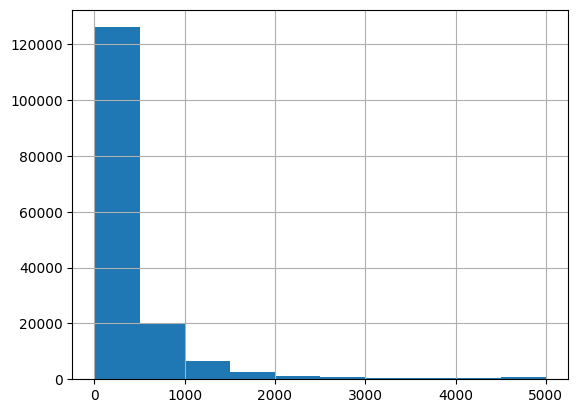

In [112]:
lens.hist();

We'll create a list of all the labels to predict, and we'll also create a 'none' label so we can see how many comments have no labels. We can then summarize the dataset.

In [113]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [114]:
len(train),len(test)

(159571, 153164)

There are a few empty comments that we need to get rid of, otherwise sklearn will complain.

In [115]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

<ipython-input-115-d2957acc749a>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[COMMENT].fillna("unknown", inplace=True)


Code to Plot Number of Occurrences per Class

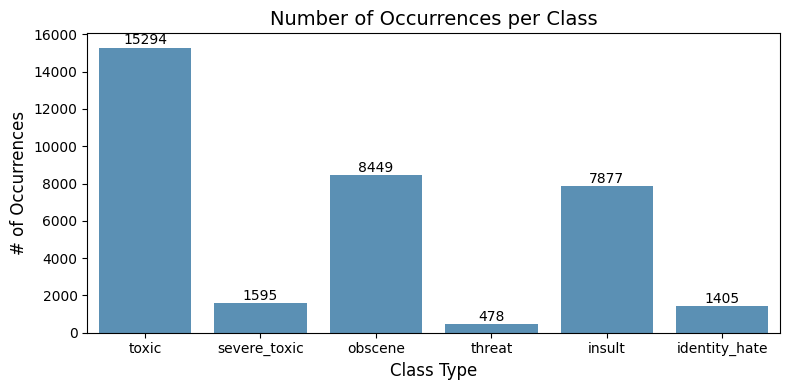

In [116]:
# Count the number of occurrences for each label in the dataset
occurrences = train[label_cols].sum()

# Plot the occurrences
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=occurrences.index, y=occurrences.values, alpha=0.8)  # Use keyword arguments for clarity
plt.title("Number of Occurrences per Class", fontsize=14)
plt.ylabel("# of Occurrences", fontsize=12)
plt.xlabel("Class Type", fontsize=12)

# Adding value labels on top of each bar
rects = ax.patches
labels = occurrences.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, int(label), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Building the model

We'll start by creating a *bag of words* representation, as a *term document matrix*. We'll use ngrams, as suggested in the NBSVM paper.

Enhanced TF-IDF vectorizer

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [118]:
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X = vectorizer.fit_transform(train["comment_text"])
y = train[label_cols].values

Naive Bayes Priors

Split the dataset into train and validation sets

In [119]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


Convert sparse matrices to dense for TensorFlow compatibility

In [120]:
X_train = X_train.toarray()
X_valid = X_valid.toarray()

Compute class weights to handle imbalanced classes

In [121]:
class_weights = {}
for i, label in enumerate(label_cols):
    class_weights[i] = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=train[label].values
    )[1]

print("Class Weights: ", class_weights)

Class Weights:  {0: 5.216784359879691, 1: 50.02225705329153, 2: 9.443188543022844, 3: 166.9152719665272, 4: 10.128919639456646, 5: 56.78683274021353}


Define callbacks

In [122]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),  # Stops if no improvement for 2 epochs
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)  # Save the best model
]

Build a neural network model

we pass it to a Dropout layer which indiscriminately "disable" some nodes so that the nodes in the next layer is forced to handle the representation of the missing data and the whole network could result in better generalization.

We set the dropout layer to drop out 10%(0.1) of the nodes.

After a drop out layer, we connect the output of drop out layer to a densely connected layer and the output passes through a RELU function. In short, this is what it does:

Activation( (Input X Weights) + Bias)

all in 1 line, with the weights, bias and activation layer all set up for you! We have defined the Dense layer to produce a output dimension of 50.

We feed the output into a Dropout layer again.

Finally, we feed the output into a Sigmoid layer. The reason why sigmoid is used is because we are trying to achieve a binary classification(1,0) for each of the 6 labels, and the sigmoid function will squash the output between the bounds of 0 and 1.

In [127]:
model = Sequential([
    Dense(50, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.1),
    Dense(6, activation='relu'),
    Dropout(0.1),
    Dense(len(label_cols), activation='sigmoid')  # Output layer with one neuron per class
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile the model

In [128]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model

We'll feed in a list of 32 padded, indexed sentence for each batch and split 10% of the data as a validation set. This validation set will be used to assess whether the model has overfitted, for each batch. The model will also run for 10 epochs, the added callback will stop the model when it reaches max accuracy.

In [129]:
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=32,  # Reduced batch size to improve generalization
                    epochs=10,  # Set maximum epochs, EarlyStopping will decide the actual number
                    verbose=1,
                    class_weight=class_weights,  # Added class weights to handle imbalance
                    callbacks=callbacks  # Added callbacks for early stopping and model checkpointing
                    )

Epoch 1/10
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.7877 - loss: 0.9199 - val_accuracy: 0.9941 - val_loss: 0.0602
Epoch 2/10
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9265 - loss: 0.3370 - val_accuracy: 0.9941 - val_loss: 0.0594


Evaluate the model on validation data

In [130]:
y_pred = model.predict(X_valid)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

998/998 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


Calculate Accuracy and F1 Score for each class

In [131]:
accuracy_scores = []
f1_scores = []

for i, label in enumerate(label_cols):
    acc = accuracy_score(y_valid[:, i], y_pred_binary[:, i])
    f1 = f1_score(y_valid[:, i], y_pred_binary[:, i])
    accuracy_scores.append(acc)
    f1_scores.append(f1)
    print(f"Class: {label}")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1 Score: {f1:.4f}")

Class: toxic
  Accuracy: 0.9568
  F1 Score: 0.7426
Class: severe_toxic
  Accuracy: 0.9899
  F1 Score: 0.0000
Class: obscene
  Accuracy: 0.9753
  F1 Score: 0.7603
Class: threat
  Accuracy: 0.9977
  F1 Score: 0.0000
Class: insult
  Accuracy: 0.9689
  F1 Score: 0.6872
Class: identity_hate
  Accuracy: 0.9908
  F1 Score: 0.0000


Calculate and display average metrics

In [132]:
avg_accuracy = np.mean(accuracy_scores)
avg_f1 = np.mean(f1_scores)

print("\nOverall Metrics:")
print(f"  Average Accuracy: {avg_accuracy:.4f}")
print(f"  Average F1 Score: {avg_f1:.4f}")


Overall Metrics:
  Average Accuracy: 0.9799
  Average F1 Score: 0.3650


Confusion Matrix for each class

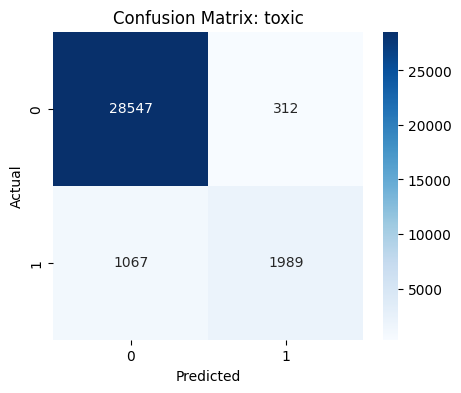

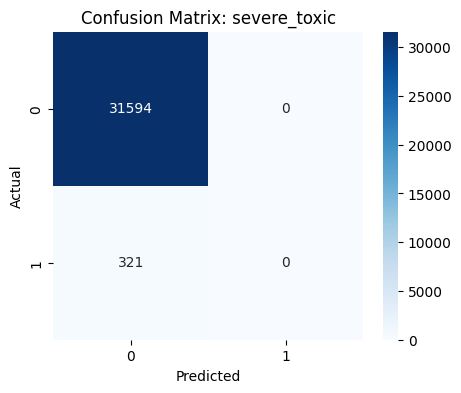

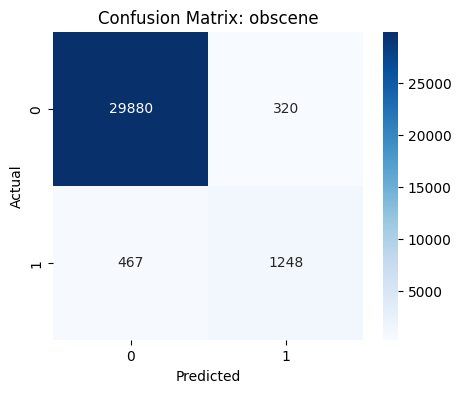

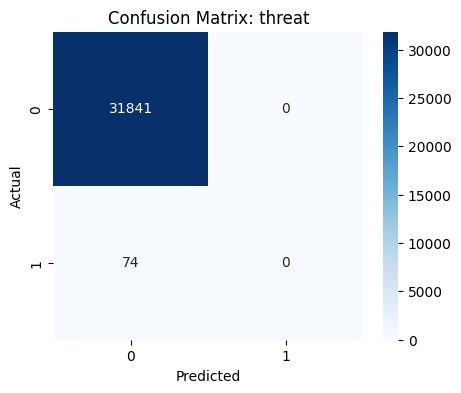

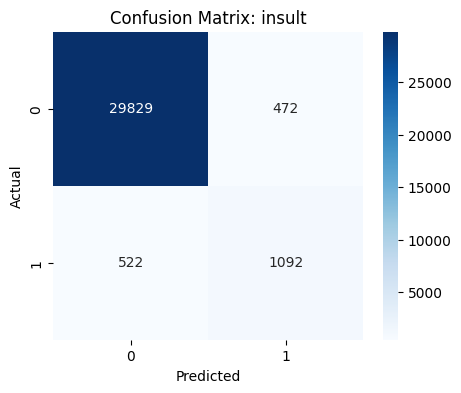

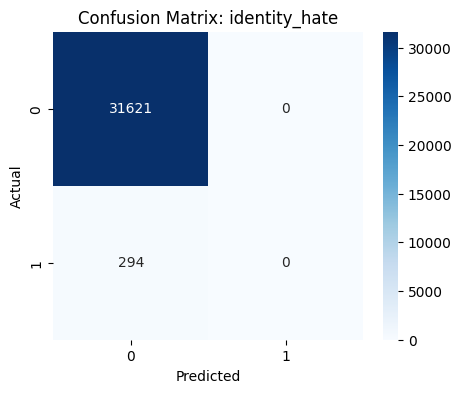

In [133]:
for i, label in enumerate(label_cols):
    cm = confusion_matrix(y_valid[:, i], y_pred_binary[:, i])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


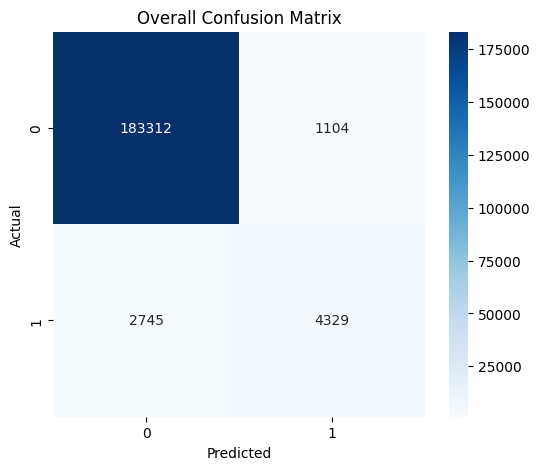

In [134]:
# Overall Confusion Matrix for the whole dataset
# Flatten predictions and true labels across all classes
y_valid_flat = y_valid.flatten()
y_pred_binary_flat = y_pred_binary.flatten()

overall_cm = confusion_matrix(y_valid_flat, y_pred_binary_flat)

plt.figure(figsize=(6, 5))
sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Blues')
plt.title("Overall Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Each cell represents the correlation value (co-occurrence strength) between the two tags. how often the tags occur together

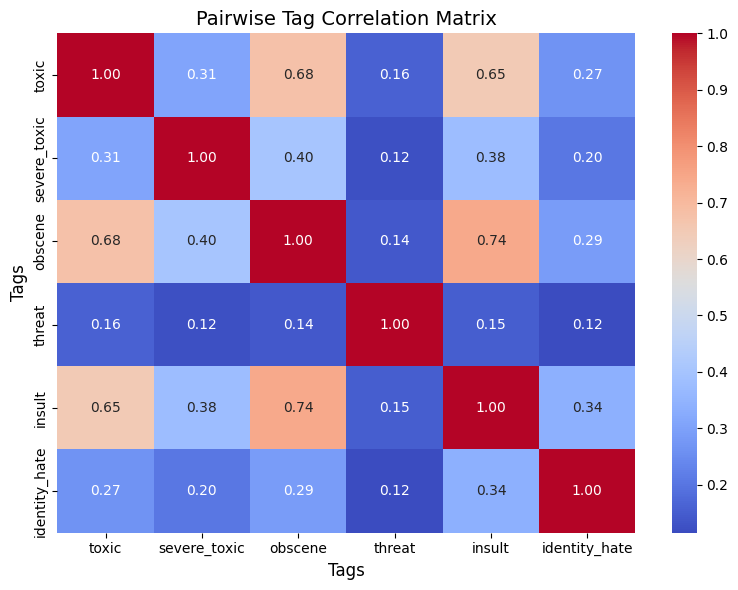

In [135]:
# Calculate the pairwise correlation matrix for the labels
tag_correlation = train[label_cols].corr()

# Plot the heatmap for tag correlation
plt.figure(figsize=(8, 6))
sns.heatmap(tag_correlation, annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
            xticklabels=label_cols, yticklabels=label_cols)
plt.title("Pairwise Tag Correlation Matrix", fontsize=14)
plt.xlabel("Tags", fontsize=12)
plt.ylabel("Tags", fontsize=12)
plt.tight_layout()
plt.show()

Training Loss and Accuracy Graphs

In [136]:
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Loss

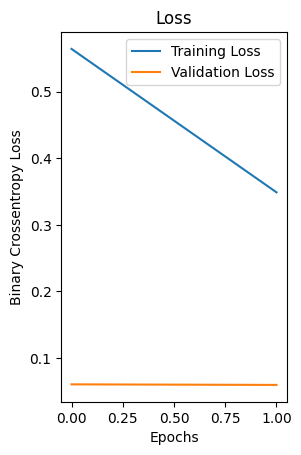

In [137]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()

plt.show()

Accuracy

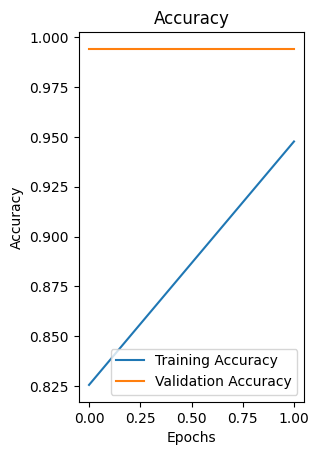

In [138]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.show()

Transform Test Data:

The test dataset (test["comment_text"]) is transformed using the same TfidfVectorizer used during training.

In [140]:
# Preprocess the test dataset
X_test = vectorizer.transform(test["comment_text"]) # Transform test data using the trained vectorizer
X_test = X_test.toarray()  # Ensure compatibility with TensorFlow

Generate Predictions:

Use the trained neural network model (model) to predict probabilities for each toxicity tag on the test data.
python
Copy code


In [141]:
# Predict probabilities for the test dataset
print("Predicting probabilities for the test dataset...")
test_preds = model.predict(X_test)

Predicting probabilities for the test dataset...
4787/4787 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


Create Submission File:

Combine id, comment_text, and the predicted probabilities for each tag into a single DataFrame.

In [142]:
# Create submission DataFrame with id, comment_text, and predicted probabilities
submid = pd.DataFrame({'id': test["id"], 'comment_text': test["comment_text"]})
submission = pd.concat([submid, pd.DataFrame(test_preds, columns=label_cols)], axis=1)

# Save the submission file
submission.to_csv('submission_with_comments.csv', index=False)

print("Submission file created: submission_with_comments.csv")

Submission file created: submission_with_comments.csv


Prediction function for a single comment

In [143]:
def predict_toxicity_comment(comment, model, vectorizer, label_cols):
    """
    Predicts the toxicity probabilities for a given comment.

    Args:
        comment (str): The user-entered comment.
        model: The trained model for predictions.
        vectorizer: The trained vectorizer to preprocess the comment.
        label_cols (list): List of toxicity labels.

    Returns:
        dict: A dictionary of predicted probabilities for each label.
    """
    # Preprocess the input comment
    processed_comment = vectorizer.transform([comment]).toarray()

    # Get the predictions from the model
    probabilities = model.predict(processed_comment)[0]  # Since we're predicting one comment, [0] extracts the row

    # Map the predictions to the labels
    predictions = {label: round(prob, 4) for label, prob in zip(label_cols, probabilities)}

    return predictions

Interactive Input Section

In [144]:
print("\n--- User Input Prediction Tool ---")
print("Enter a comment to analyze its toxicity probabilities.")
print("Type 'exit' to quit the tool.\n")

while True:
    # Ask the user for input
    user_comment = input("Enter a comment to analyze (or type 'exit' to quit): ")

    if user_comment.lower() == 'exit':
        print("Exiting the prediction tool. Goodbye!")
        break

    # Predict the probabilities
    predictions = predict_toxicity_comment(user_comment, model, vectorizer, label_cols)

    # Display the results
    print("\nPredicted Toxicity Probabilities:")
    for label, prob in predictions.items():
        print(f"  {label}: {prob * 100:.2f}%")


--- User Input Prediction Tool ---
Enter a comment to analyze its toxicity probabilities.
Type 'exit' to quit the tool.

Enter a comment to analyze (or type 'exit' to quit): Im a fucking bitch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Predicted Toxicity Probabilities:
  toxic: 99.29%
  severe_toxic: 37.17%
  obscene: 97.71%
  threat: 0.51%
  insult: 83.67%
  identity_hate: 12.21%
Enter a comment to analyze (or type 'exit' to quit): What a motherfucking piece of crap those fuckheads for blocking us!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Predicted Toxicity Probabilities:
  toxic: 90.26%
  severe_toxic: 30.39%
  obscene: 81.27%
  threat: 6.31%
  insult: 66.34%
  identity_hate: 20.52%
Enter a comment to analyze (or type 'exit' to quit): You are gay or antisemmitian? 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Predicted Toxicity Probabilities:
  toxic: 75.69%
  severe_toxic: 29.06%
  obscene: 63.83%
  threat: 16.09%
  insult: 57.42%
  identity_hate: 25.47%
Enter a comment to analyze (or type 'ex